In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Terraform,48.854440,24.427220,25.216555,2
OAuth 2.0 RFC6749,133.168128,16.646016,40.948766,8
Node.js and Vite,152.147183,3.710907,12.989560,41
Django,154.397242,3.859931,9.589119,40
Azure Functions + PP365,180.011871,36.002374,56.778959,5
pfSense,460.878913,38.406576,129.014871,12
CCH Tax Forms Project,501.491902,23.880567,91.676419,21
Accounting,584.589314,34.387607,93.041971,17
Python + Oauth2.0,738.323034,32.101001,104.235300,23
FSLogix,860.239658,71.686638,160.545404,12


# Histogram

sum of ages: ~43161.02


<Axes: >

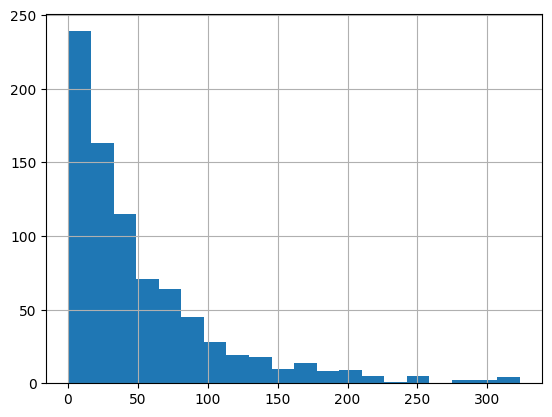

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~43161.02


<Axes: >

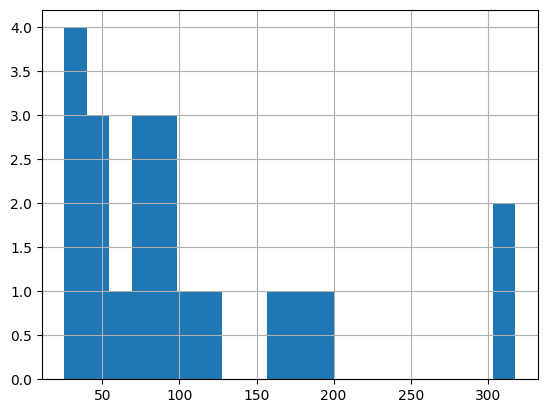

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='VMWare']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [8]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [9]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 822
Total card age: 43161.02


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
1,VMWare,vCenter Server Appliance (VCSA)\n\nA Linux-bas...,e36bc4e0beec02099cc594bb7a9786e1,-317.827151,-105.641042,317.827151,2218.461873,0.293055,21,0,0
35,VMWare,Distributed Resource Scheduler (DRS)\n\nA feat...,aacf20a6e4b4c58031bbd7227c0e5b9a,-183.567685,-105.641042,317.827151,2218.461873,0.293055,21,3,0
117,VMWare,Storage I/O Control (SIOC)\n\nA feature in VMw...,2cbf040c2cb860c41205e5dfa12b0990,-101.950943,-105.641042,317.827151,2218.461873,0.293055,21,6,0
161,VMWare,vMotion\n\nA VMware feature that allows the li...,a92e4d7575a4249179371695df2b1e9a,-91.259679,-105.641042,317.827151,2218.461873,0.293055,21,9,0
175,VMWare,vSphere Cluster\n\nA group of ESXi hosts that ...,6aa4ebf94b7dcdc4dda0e92dfcad3a6e,-76.808654,-105.641042,317.827151,2218.461873,0.293055,21,12,0
347,VMWare,ESXi Console Access\n\nThe ability to access t...,22781c1d36396ea349feb1cbb8509f59,-45.700668,-105.641042,317.827151,2218.461873,0.293055,21,15,0
517,VMWare,vMotion Network\n\nA dedicated network connect...,9a98ed2dabbe6ebed330e959c93e87dd,-28.099234,-105.641042,317.827151,2218.461873,0.293055,21,18,0
0,Azure VM + Developer,Startup Script / Bootstrap Script\nA script (B...,2284d106ece03375e77e80abad2ce923,-323.004490,-98.010296,323.004490,3038.319175,0.527697,31,0,0
34,Azure VM + Developer,12-Factor App\nA set of best practices for bui...,7335f65e5504783dbbd6a4463ac255f3,-185.171198,-98.010296,323.004490,3038.319175,0.527697,31,3,0
73,Azure VM + Developer,Remote Development\nA workflow where the code ...,8768fbbd3be8e62c25be8705689bbc02,-134.696958,-98.010296,323.004490,3038.319175,0.527697,31,6,0


## Age Max

In [10]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // 5

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [11]:
# n=4
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [13]:
existing_cards.head(10)['age'].sum()

np.float64(-1488.086660607632)

In [14]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
0,Azure VM + Developer,Startup Script / Bootstrap Script\nA script (B...,2284d106ece03375e77e80abad2ce923,-323.004490,-98.010296,323.004490,3038.319175,0.527697,31,0,0
1,VMWare,vCenter Server Appliance (VCSA)\n\nA Linux-bas...,e36bc4e0beec02099cc594bb7a9786e1,-317.827151,-105.641042,317.827151,2218.461873,0.293055,21,0,0
2,Asynchronous Python,Race Condition\nA race condition occurs when m...,56259820681abe2cac07ac869cd50777,-315.999788,-64.723448,315.999788,1423.915865,0.520300,22,0,0
3,TSQL,Stored Procedures:\n\nPrecompiled TSQL routine...,1c1c29f98d6c0bd8774d3c31bfcdd3e4,-314.425794,-60.495049,314.425794,1451.881181,0.518131,24,0,0
4,VMWare,Host Failure\n\nWhen a physical ESXi host beco...,50554350b937a4d45efe1e2ea91d1c85,-305.233274,-105.641042,317.827151,2218.461873,0.293055,21,1,1
5,Terraform Codebox,Process segmentation fault (Segmentation fault...,e4cf055569f377aaeff23124919e4d27,-291.243342,-58.782862,291.243342,2880.360216,0.053477,49,0,0
6,Vocab,"Something Rotten, Fforde\nPaella\nnoun | pah-A...",a37b3188a1d9c867d96671c96fbb61bf,-282.618101,-82.957748,282.618101,3484.225402,0.619453,42,0,0
7,PnP PowerShell,PSCredential (Microsoft.PowerShell.Security)\n...,58979b94f2077e07481d767d7e748fc9,-280.703706,-69.704571,280.703706,2509.364555,0.437395,36,0,0
8,Azure Compute Gallery,Compute Gallery Resource – The top-level conta...,cd4e5ebc6131cac516f3b36cdc1af298,-257.501236,-83.504783,257.501236,2338.133918,0.812438,28,0,0
10,Azure Compute Gallery,One Compute Gallery Per Subscription – ACG is ...,7b7b4f84c6bc6891a0e1e7cf19f2922e,-250.148197,-83.504783,257.501236,2338.133918,0.812438,28,1,1


In [15]:
existing_cards['age'].mean()

np.float64(-52.50732401853505)